# What is credit risk?

Credit risk is the risk that a borrower will not pay back(also called **default**) the lender as per the expected schedule. This risk is central to how lending fintech organisations and banks run. 

In conventional lending organisations, and in fact all lending organisations a 100 years back, there are employees who are in charge of assesing the credit risk of each borrower. They look at parameters such as your previous credit history(which they get from a credit bureau), income,professional qualifications etc. 



![alt text](automationjourney.png "Title")

Different organisations are at different stages of the automation cycle becuase of access to technology, talent and different regulation. However, almost all organisations involved in the lending business hire data scientists who specialise in building credit risk models in house. 

# Why use models?

- are cheaper
- are faster
- dont exhibit human bias and variance
- depending on the quality and quantity of the data that was used to train it, might make deciions of equal to a trained credit professional

For a while now, developing and maintaining scorecards has has **a very positive ROI for financial institutions**. You will see every lender implement and maintain their own scorecard. As such, the credit risk industry is one of the oldest employers of data scientists, even before the current data science boom.

This has been possible because of -

- Available of highly structured information digitally and for cheap (bureaus)
- Scale
- Storage and compute becoming cheaper

## Defining the objective

Imagine this conversation:

Data scientist - "I have built a great credit risk model for mortgage lending which has an AUC of 0.7 using credit bureau data. It is at par with the kind of decisions our credit officers are taking. We can completely automate this and we will have no need for credit officers."

Risk head - "Well, mortgage loans are very complicated. We look at much more data apart from credit bureaus which is structured/unstructured and have to go through a lot of manual precesses that are mandatory from a regulatory standpoint."

Data Scientist - "So we cannot use the model I built?"

Risk head - "We can. It can be another parameter for our credit officer to look at and they can incorporate that into thier decision making. But the final decision will be from a credit officer and not automated."

Data Scientist - "Ohh, I see."

Risk head - "You should have spoken to me first. Something like this in the retail personal loan space can really change the game. Mortgage lending is a different beast"



<img src="stress.jpeg" alt="drawing" width="200" height = "100"/>

## Types of objectives 

- **Improve productivity** or partial automation in the risk assesment workflow. You want to take similar quality decisions but faster, with less resources. Benchmark is the time and resources being used currently.

- **Control credit risk**. You want to make better decisions than the current setup. Benchmark current portfolio quality and defaullt rates. 

- Assess the quality of the current portfolio and estimate the **portfolio risk**. Benchmark is the current model. 



## Framing the problem

Risk head - "Can we build a credit risk model which can **approve/reject** loan applications based on all the data points we capture in the loan application. there will be no manual judgement involved, the model's word will be final."

We have to build an **application scoring model**. We also have to figure out **probability decision boundry** for approval/rejection.

- What are the features we can use? We can only use features which were available at the application stage
- What should be the output of the model? The model has to output a decision rather than a probability score.

We, the data scientists can frame this as **supervised binary classification problem**. The model will be trained on past loans where target is already known. Each of these loans would either have defaulted or not. 



# Creating the dataset


## The target

Till now we have only alluded to "default" in an abstract sense. However, to create the target variable from historic data, we will need an exact definition. The regulatory business definitions of default usually are the same across organisations. For term loans with EMIs, it is usually the event of a borrower missing 3 consecutive monthly payments(90 days past due). 

## The features

- Calculate features in a way that is replicable when the model will be deployed.
- Create as many features as possible. 
- Feature engineering is very important.

We take the data from here - https://www.kaggle.com/competitions/home-credit-default-risk/data?select=application_train.csv


# Building the model 

## Feature exploration and selection
We try to understand the feature distributions and their relationships with the target variable. In binary classification problems, the metric generally sued to measure bivariate relationship strength is the **Information value**. 

https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence/

This metric is rooted in information theory, specifically the Jensen Shanon divergence. Think of this like the equivaluent of Pearson correlation, which is used when the target variable is continuous.

We will rely on the optbinning package to claculate this.


In [25]:
import pandas as pd
import numpy as np
import utils
import py_mob
from tqdm import tqdm
data_in = pd.read_csv("application_train.csv").drop(columns = "SK_ID_CURR")
data_in

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
data_in["TARGET"].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [29]:
from optbinning import OptimalBinning
from pandas.api.types import is_numeric_dtype

target = "TARGET"
features = [x for x in data_in.columns if x!= target]


binned_features = {}

def get_binning(x,y,params={}):
    """
    Get binning result for independent variable  with the target variable y
    """
    if is_numeric_dtype(x):
        optb = OptimalBinning(name=feat, dtype="numerical", solver="cp",**params)
    else :
        optb = OptimalBinning(name=feat, dtype="categorical", solver="mip",**params)
    optb.fit(x, y)
    binning_table = optb.binning_table
    binning_table.build()
    return binning_table,optb
    
for feat in features:
    x = data_in[feat].values
    y = data_in[target]
    
    binning_result = get_binning(x,y)
    binned_features.update({feat :binning_result})


In [32]:
feature_strength = pd.DataFrame([ (x,y[0].iv) for x,y in binned_features.items() ]).rename(columns = {0:"feature" , 1:"iv"}).sort_values("iv",ascending=False)
feature_strength.head(10)

,feature,iv
41,EXT_SOURCE_3,0.335262
40,EXT_SOURCE_2,0.321683
39,EXT_SOURCE_1,0.146393
16,DAYS_EMPLOYED,0.114354
8,AMT_GOODS_PRICE,0.092037
15,DAYS_BIRTH,0.087245
26,OCCUPATION_TYPE,0.079610
38,ORGANIZATION_TYPE,0.071642
6,AMT_CREDIT,0.059368
10,NAME_INCOME_TYPE,0.057869


In [4]:
feature_strength.iv.describe(np.linspace(0,1,11))

count    120.000000
mean       0.027153
std        0.045787
min        0.000000
0%         0.000000
10%        0.000000
20%        0.000666
30%        0.011504
40%        0.013225
50%        0.017755
60%        0.022416
70%        0.028736
80%        0.033208
90%        0.048451
100%       0.335262
max        0.335262
Name: iv, dtype: float64

A lot of features have very low IV(< 0.05). Generally we have compute constraints and thus want to remove features which will not add any value to our model. But any feature that has even slight predictive ability, should be included in the training process and the model shoudl itlsef learn how important it is.

Since we are not training a linear regression model, **we are not overly concerned with collinearily**.

## Exploring individual features

In [41]:
binned_features['OCCUPATION_TYPE'][0].build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Accountants, High skill tech staff]",21193,0.068918,20018,1175,0.055443,0.402878,0.009460,0.001175
1,[Managers],21371,0.069497,20043,1328,0.062140,0.28172,0.004904,0.000611
2,"[Core staff, HR staff, IT staff, Private servi...",41904,0.136268,39198,2706,0.064576,0.240669,0.007138,0.000890
3,"[Cleaning staff, Sales staff]",36755,0.119524,33216,3539,0.096286,-0.193298,0.004843,0.000604
4,"[Cooking staff, Laborers, Security staff]",67853,0.220652,60672,7181,0.105832,-0.298442,0.022275,0.002774
5,"[Waiters/barmen staff, Drivers, Low-skill Labo...",22044,0.071685,19426,2618,0.118762,-0.428284,0.015735,0.001952
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,96391,0.313455,90113,6278,0.065131,0.231527,0.015254,0.001902
Totals,,307511,1.000000,282686,24825,0.080729,,0.079610,0.009909


In [34]:
selected_features = [ feat_name for feat_name,iv in zip( feature_strength["feature"],feature_strength["iv"] ) if iv>0.05 ]
len(selected_features)

11

In [7]:
data_in[selected_features].dtypes

EXT_SOURCE_3                   float64
EXT_SOURCE_2                   float64
EXT_SOURCE_1                   float64
DAYS_EMPLOYED                    int64
AMT_GOODS_PRICE                float64
DAYS_BIRTH                       int64
OCCUPATION_TYPE                 object
ORGANIZATION_TYPE               object
AMT_CREDIT                     float64
NAME_INCOME_TYPE                object
REGION_RATING_CLIENT_W_CITY      int64
dtype: object

## Model training

## Why choose tree models

- scale invariant
- robust to multi-collinearity
- robust to outliers
- proven to be SOTA for tabular data modelling
- lightgbm additionally handles categorical variables as well.

In [35]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'max_depth': [3, 4],
        'learning_rate' : [0.001, 0.01,0.1],
        'colsample_bytree': [0.1, 0.2],
        }


clf = lgb.LGBMClassifier(
    verbose_eval=False,
    objective = 'binary',
    boosting_type = 'gbdt',
    seed= 0,
    verbose= -1,
    metric = 'auc',
    nthread = 16,
)
folds = 3

## always use stratified sampling
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

data_features = data_in[selected_features]
data_target =  data_in[target]

for c in data_features.columns:
    if data_features[c].dtype.name == 'object':
        data_features[c] = data_features[c].astype('category')

X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.33, random_state=42)

grid_search = GridSearchCV(clf, param_grid=params, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3 )

# Here we go
grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_threads is set with nthread=16, will be overridden by n_jobs=-1. Current value: num_threads=-1


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fe6898556d0>,
             estimator=LGBMClassifier(metric='auc', nthread=16,
                                      objective='binary', seed=0, verbose=-1,
                                      verbose_eval=False),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.1, 0.2],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 4], 'min_child_weight': [1, 5, 10]},
             scoring='roc_auc', verbose=3)

In [36]:
print(grid_search.best_params_, grid_search.best_score_)

{'colsample_bytree': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5} 0.738448248417353


In [37]:
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = selected_features
feature_importance_df["importance"] = grid_search.best_estimator_.feature_importances_

In [ ]:
feature_importance_df.sort_values("importance", ascending = False)

## Choosing the right objective

THE ROC AUC is the most popular measure to judge binary classifiers


In [12]:
from sklearn.metrics import roc_auc_score

classifier = grid_search.best_estimator_
classifier.fit(X_train,y_train)
y_train_probs = classifier.predict_proba(X_train)[:, 1]
y_test_probs = classifier.predict_proba(X_test)[:, 1]
train_auc = roc_auc_score(y_train, y_train_probs)
test_auc = roc_auc_score(y_test, y_test_probs)
print(f"Model results. Train AUC : {train_auc}. Test AUC : {test_auc}")

Model results. Train AUC : 0.7512325723010003. Test AUC : 0.7410746750339658


In [23]:
from utils import ks
test_result_df = pd.DataFrame({"target" : y_test , "proba": y_test_probs })
summary_table = ks(test_result_df,"target","proba")
summary_table

,min_prob,max_prob,events,nonevents,total,bucket_event_rate,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,,,
1,0.160580,0.720928,2554,7594,10148,0.251675,31.46%,8.13%,31.46%,8.13%,23.3
2,0.114877,0.160578,1451,8697,10148,0.142984,17.88%,9.32%,49.34%,17.45%,31.9
3,0.090321,0.114875,1081,9067,10148,0.106523,13.32%,9.71%,62.66%,27.16%,35.5
4,0.074026,0.090320,807,9341,10148,0.079523,9.94%,10.01%,72.60%,37.17%,35.4
5,0.061259,0.074025,622,9525,10147,0.061299,7.66%,10.20%,80.26%,47.37%,32.9
6,0.051107,0.061258,508,9640,10148,0.050059,6.26%,10.33%,86.52%,57.69%,28.8
7,0.042400,0.051107,398,9750,10148,0.039220,4.90%,10.44%,91.43%,68.14%,23.3
8,0.034343,0.042399,309,9839,10148,0.030449,3.81%,10.54%,95.23%,78.68%,16.6
9,0.026075,0.034343,237,9911,10148,0.023354,2.92%,10.62%,98.15%,89.29%,8.9


# Explainability in credit risk models

## Shapley values





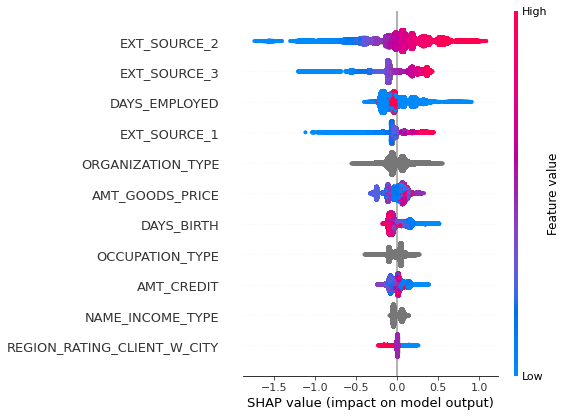

In [16]:

import shap
explainer = shap.TreeExplainer(classifier.booster_)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[0], X_train)


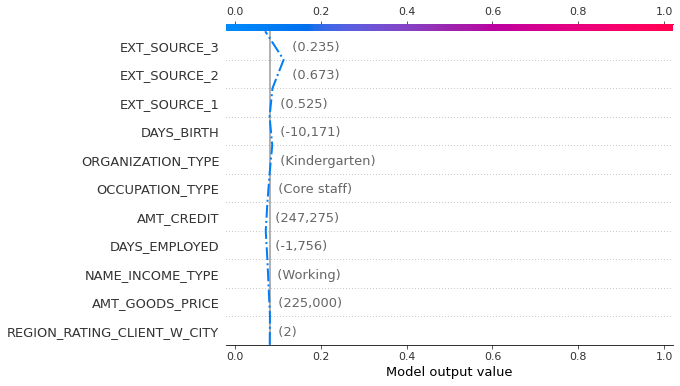

In [40]:

obs_idx = 780 # Relates to a specific observation

shap.decision_plot(np.log(y_train_probs.mean()/(1-y_train_probs.mean())), shap_values[0][obs_idx], X_train.iloc[obs_idx],link='logit',
                   highlight=0)


In [39]:
y_train_probs[780]

0.07417716503023877

# Post Model deployment

- Data drift https://deepchecks.com/data-drift-vs-concept-drift-what-are-the-main-differences/
- Concept drift
- Model performance check
- Reject inferencing


# Advise?

Focus on the lending business and gain an understnading on what factors drive risk
Models and algorithms will not differentiate you. More data, better feature enginerring and robust feature selection will.
Development of the model is a job only half done. A model is never done, it has its life.

## References
[1]https://www.kaggle.com/competitions/home-credit-default-risk/overview

[1] Shapley values : https://python-bloggers.com/2021/09/training-xgboost-model-and-assessing-feature-importance-using-shapley-values-in-sci-kit-learn/#:~:text=The%20Shapley%20value%20is%20the,from%20the%20machine%20learning%20model.

[2] Jensen SHannon Divergence : https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence

[3] ROC AUC https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc